In [69]:
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(17, 7))

import catboost
import lightgbm as lgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# label encoding
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [70]:
from sklearn.metrics import mean_squared_error
import math
def rmse(y, y_pred):
    return math.sqrt(mean_squared_error(y, y_pred))

### Loading preprocessed-data

In [71]:
all_data = pd.read_pickle('/kaggle/working/pickled_df.pkl')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8801351 entries, 0 to 8801350
Data columns (total 44 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   shop_id                             int32  
 1   item_id                             int32  
 2   date_block_num                      int32  
 3   item_cnt_month                      float32
 4   shop_type                           int32  
 5   city_enc                            int8   
 6   item_category_id                    int32  
 7   category_enc                        int32  
 8   subtype_code                        int32  
 9   item_cnt_month_lag-3                float32
 10  item_cnt_month_lag-2                float32
 11  item_cnt_month_lag-1                float32
 12  item_rate_month_lag-3               float32
 13  item_rate_month_lag-2               float32
 14  item_rate_month_lag-1               float32
 15  item_price_lag-3                    float32
 16  

In [72]:
#we will not use the data of 2013
all_data = all_data[all_data.date_block_num>11]
all_data.shape

(5452521, 44)

## Modeling

#### Train/Val splitting

We will treat last month data as the test set.

In [73]:
# Saving `date_block_num`, as we can will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print("Test 'date_block_num' is %d" % last_block)

Test 'date_block_num' is 34


In [74]:
dates_train = dates[dates <  33]
dates_validate  = dates[dates == 33]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  33].drop('item_cnt_month', axis=1)
X_val =  all_data.loc[dates == 33].drop('item_cnt_month', axis=1)
X_test =  all_data.loc[dates == last_block].drop('item_cnt_month', axis=1)

y_train = all_data.loc[dates <  33, 'item_cnt_month'].values
y_val =  all_data.loc[dates == 33, 'item_cnt_month'].values

In [112]:
# a dict to store each model and its corresponding RMSE
models = {}

## LightGBM

**Advantages of Using LightGBM**

LightGBM offers several advantages for machine learning tasks:

* Speed: LightGBM is exceptionally fast and memory-efficient, making it suitable for large datasets.
* Accuracy: It often achieves state-of-the-art results in various machine learning competitions and real-world applications.
* Parallel and Distributed Training: LightGBM supports parallel and distributed training, enabling faster model development.
* Regularization: It provides built-in L1 and L2 regularization to prevent overfitting.
* Feature Importance: Comprehensive feature importance analysis helps in better model understanding and feature selection.

In [75]:
# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 273,
          'learning_rate': 0.007,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise':True
         }

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_val, y_val)

# Train LightGBM model
model = lgb.train(params=params,
                  train_set=dtrain,
                  num_boost_round=1500,
                  valid_sets=(dtrain, dvalid),
                  early_stopping_rounds=150,
                  verbose_eval=100)

[LightGBM] [Info] Total Bins 4585
[LightGBM] [Info] Number of data points in the train set: 5016645, number of used features: 43
[LightGBM] [Info] Start training from score 0.299950
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.92845	valid_1's rmse: 0.882038
[200]	training's rmse: 0.826263	valid_1's rmse: 0.841925
[300]	training's rmse: 0.782811	valid_1's rmse: 0.839102
[400]	training's rmse: 0.759752	valid_1's rmse: 0.842014
Early stopping, best iteration is:
[286]	training's rmse: 0.78719	valid_1's rmse: 0.838517


In [76]:
pred_lgb = model.predict(X_val).clip(0.20)
print('Val root mean squared error for LightGBM is %f' % rmse(y_val, pred_lgb))

Val root mean squared error for LightGBM is 0.846969


In [77]:
test_pred_lgb = model.predict(X_test).clip(0.20)

In [113]:
models['LightGBM'] = rmse(y_val, pred_lgb)

### Plot feature importance using Gain and Split

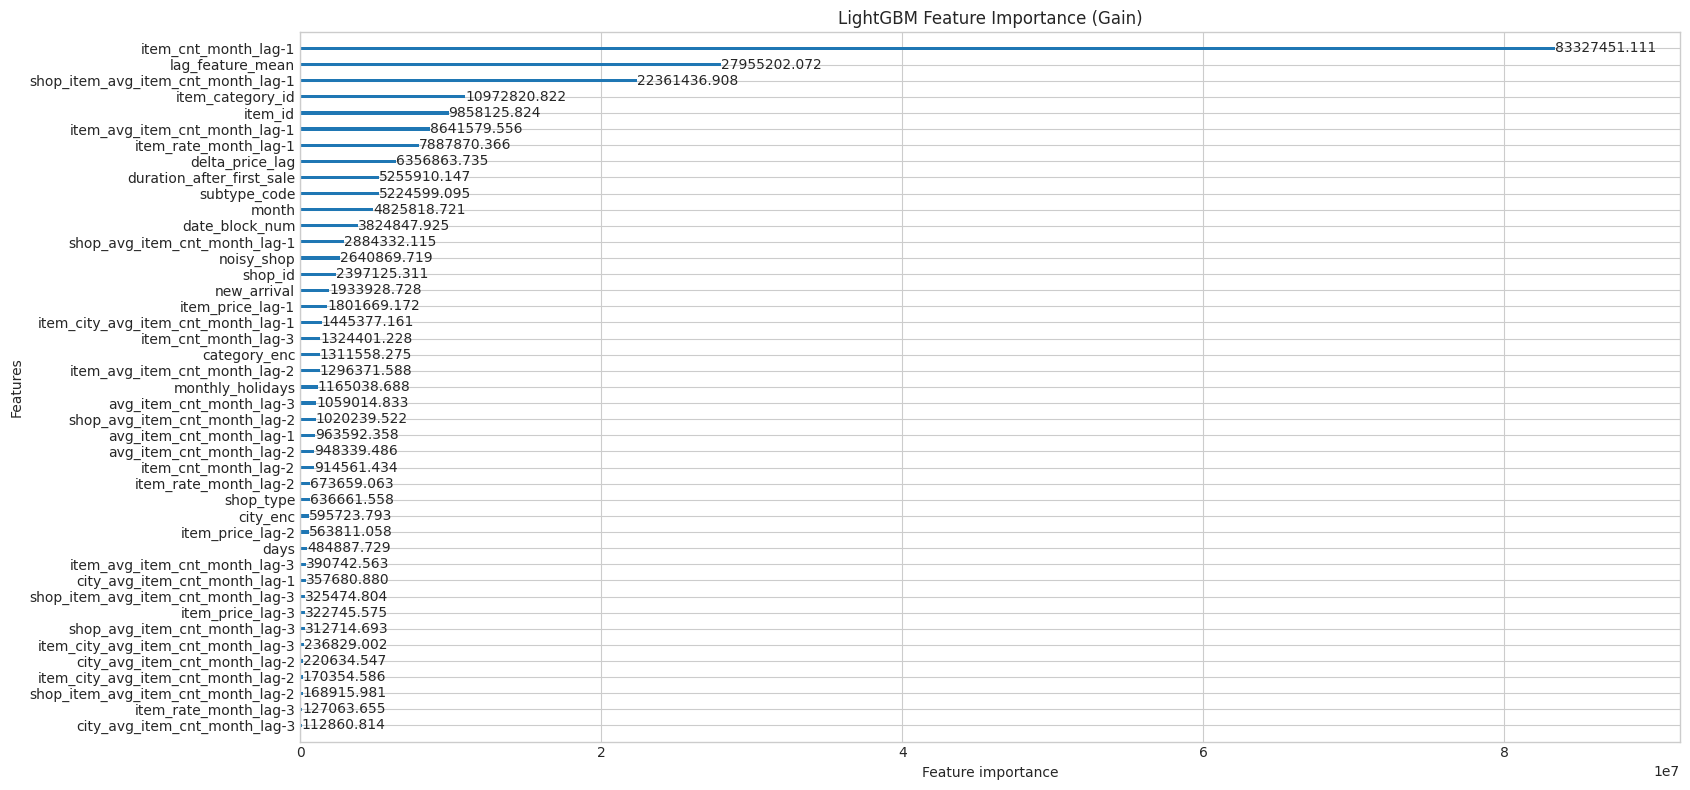

In [78]:
# Plot feature importance using Gain
lgb.plot_importance(model, importance_type="gain", figsize=(17, 8), title="LightGBM Feature Importance (Gain)")
plt.show()

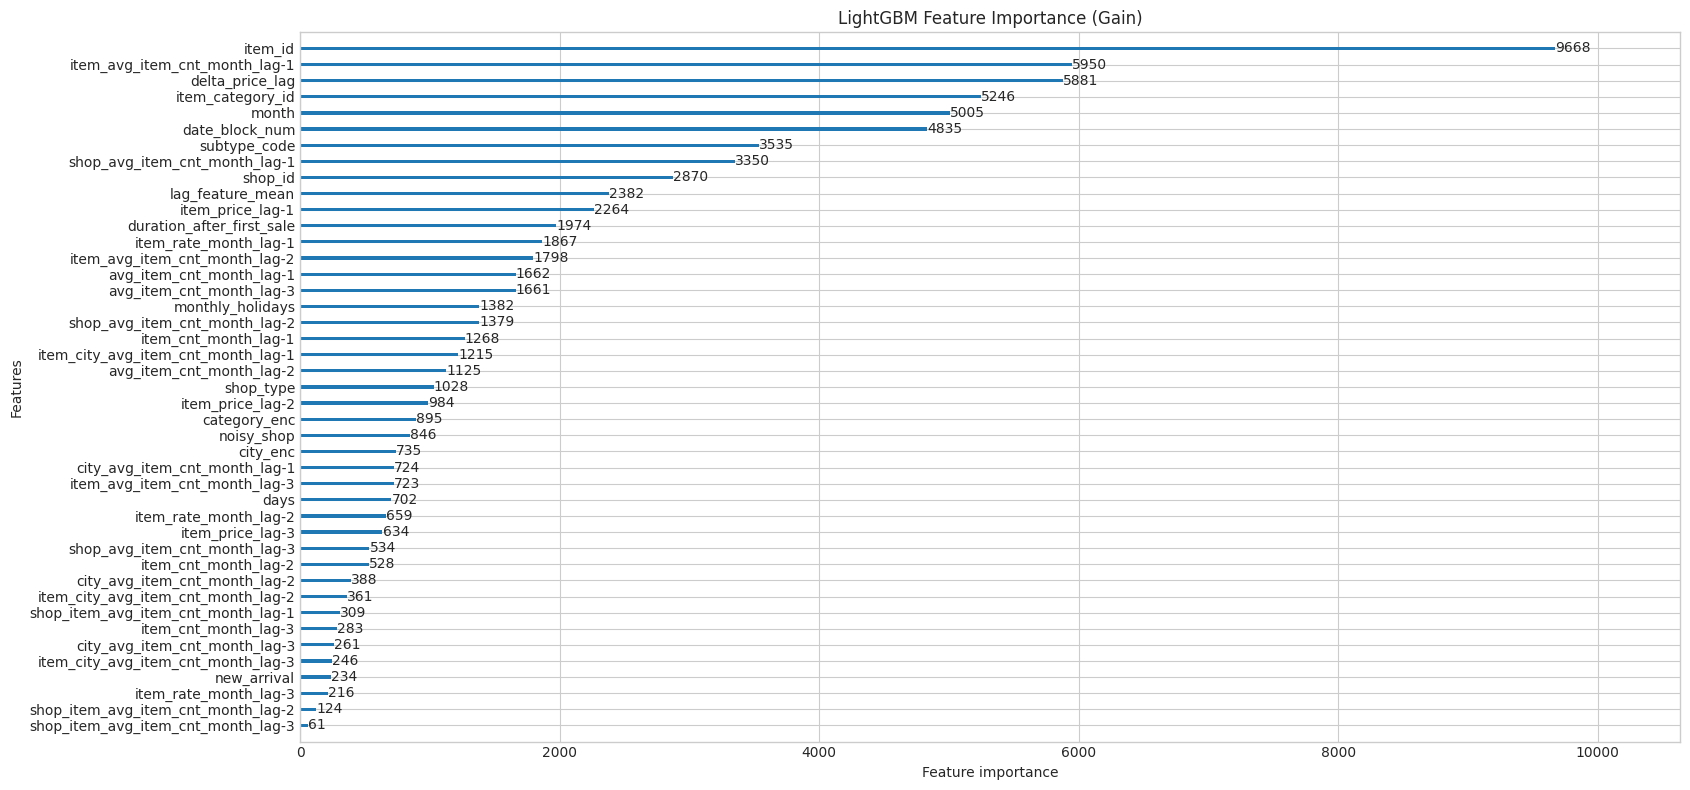

In [79]:
# Plot feature importance using Gain
lgb.plot_importance(model, importance_type="split", figsize=(17, 8), title="LightGBM Feature Importance (Gain)")
plt.show()

### XGBoost

In [80]:
xgb_model = XGBRegressor(max_depth = 10,
                        n_estimators = 1000,
                        min_child_weight = 5, 
                        subsample = 0.6, 
                        cosample_bytree = 0.6,
                        alpha = 0.1,
                        eta = 0.007, 
                        seed = 42)

xgb_model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 100)

[0]	validation_0-rmse:1.19855	validation_1-rmse:1.07586
[1]	validation_0-rmse:1.19422	validation_1-rmse:1.07220
[2]	validation_0-rmse:1.18995	validation_1-rmse:1.06872
[3]	validation_0-rmse:1.18573	validation_1-rmse:1.06523
[4]	validation_0-rmse:1.18154	validation_1-rmse:1.06174
[5]	validation_0-rmse:1.17740	validation_1-rmse:1.05843
[6]	validation_0-rmse:1.17326	validation_1-rmse:1.05511
[7]	validation_0-rmse:1.16920	validation_1-rmse:1.05186
[8]	validation_0-rmse:1.16517	validation_1-rmse:1.04853
[9]	validation_0-rmse:1.16116	validation_1-rmse:1.04512
[10]	validation_0-rmse:1.15718	validation_1-rmse:1.04193
[11]	validation_0-rmse:1.15326	validation_1-rmse:1.03883
[12]	validation_0-rmse:1.14938	validation_1-rmse:1.03574
[13]	validation_0-rmse:1.14552	validation_1-rmse:1.03264
[14]	validation_0-rmse:1.14170	validation_1-rmse:1.02941
[15]	validation_0-rmse:1.13795	validation_1-rmse:1.02635
[16]	validation_0-rmse:1.13423	validation_1-rmse:1.02339
[17]	validation_0-rmse:1.13053	validation

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, cosample_bytree=0.6, device=None,
             early_stopping_rounds=None, enable_categorical=False, eta=0.007,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000, ...)

In [81]:
pred_xgb = xgb_model.predict(X_val).clip(0.20)
print('Val root mean squared error for XGBoost is %f' % rmse(y_val, pred_xgb))

Val root mean squared error for XGBoost is 0.814268


In [82]:
test_pred_xgb = xgb_model.predict(X_test).clip(0.20)

In [120]:
models['XGBoost'] = rmse(y_val, pred_xgb)

## Linear Regression

In [83]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_val.values).clip(0.20)

print('Val rmse for linreg is %f' % rmse(y_val, pred_lr))

Val rmse for linreg is 0.892603


In [84]:
test_pred_lr = lr.predict(X_test.values).clip(0.20)

In [115]:
models['LinearReg'] = rmse(y_val, pred_lr)

## CatBoost

In [85]:
cb_model = CatBoostRegressor(
            iterations =1500,
            random_seed=13,
            learning_rate =0.01,
            loss_function ='RMSE',
            od_wait =100,
            od_type ='Iter',
            eval_metric ='RMSE',
)
cb_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    logging_level='Verbose',
    #verbose=True
)

0:	learn: 1.1985030	test: 1.0760021	best: 1.0760021 (0)	total: 586ms	remaining: 14m 38s
1:	learn: 1.1941279	test: 1.0726177	best: 1.0726177 (1)	total: 1.07s	remaining: 13m 23s
2:	learn: 1.1898267	test: 1.0692741	best: 1.0692741 (2)	total: 1.58s	remaining: 13m 7s
3:	learn: 1.1856173	test: 1.0659680	best: 1.0659680 (3)	total: 2.07s	remaining: 12m 52s
4:	learn: 1.1814695	test: 1.0627054	best: 1.0627054 (4)	total: 2.57s	remaining: 12m 47s
5:	learn: 1.1773798	test: 1.0595840	best: 1.0595840 (5)	total: 3.04s	remaining: 12m 38s
6:	learn: 1.1732855	test: 1.0563231	best: 1.0563231 (6)	total: 3.55s	remaining: 12m 38s
7:	learn: 1.1693183	test: 1.0533157	best: 1.0533157 (7)	total: 4.03s	remaining: 12m 32s
8:	learn: 1.1654029	test: 1.0503393	best: 1.0503393 (8)	total: 4.53s	remaining: 12m 30s
9:	learn: 1.1615866	test: 1.0474906	best: 1.0474906 (9)	total: 5s	remaining: 12m 25s
10:	learn: 1.1577421	test: 1.0443627	best: 1.0443627 (10)	total: 5.58s	remaining: 12m 34s
11:	learn: 1.1539441	test: 1.04135

In [86]:
pred_cb = cb_model.predict(X_val).clip(0.20)
print('Val root mean squared error for CatBoost is %f' % rmse(y_val, pred_cb))

Val root mean squared error for CatBoost is 0.825746


In [87]:
test_pred_cb = cb_model.predict(X_test).clip(0.20)

In [116]:
models['CatBoost'] = rmse(y_val, pred_cb)

### Multi-layer Perceptron Regressor

In [88]:
mlp = MLPRegressor(random_state=1, 
                    max_iter=10, 
                    learning_rate_init= 0.01,
                    verbose=True)
mlp.fit(X_train, y_train)

Iteration 1, loss = 355.04503330
Iteration 2, loss = 0.80866763
Iteration 3, loss = 0.72370316
Iteration 4, loss = 0.72371940
Iteration 5, loss = 0.72371464
Iteration 6, loss = 0.72371681
Iteration 7, loss = 0.72370468
Iteration 8, loss = 0.72372280
Iteration 9, loss = 0.72370926
Iteration 10, loss = 0.72371005


MLPRegressor(learning_rate_init=0.01, max_iter=10, random_state=1, verbose=True)

In [90]:
pred_mlp = mlp.predict(X_val).clip(0.20)
print('Val root mean squared error for nn is %f' % rmse(y_val, pred_mlp))

Val root mean squared error for nn is 1.079327


In [92]:
test_pred_mlp = mlp.predict(X_test).clip(0.20)

In [117]:
models['MLPRegressor'] = rmse(y_val, pred_mlp)

# Stacking

## LR

In [93]:
stacked_valid_preds = np.c_[pred_lgb, pred_xgb, pred_cb, pred_lr, pred_mlp]
stacked_test_preds = np.c_[test_pred_lgb, test_pred_xgb, 
                           test_pred_cb, test_pred_lr, test_pred_mlp]

In [94]:
lr = LinearRegression()
lr.fit(stacked_valid_preds, y_val)

pred_stacked = lr.predict(stacked_valid_preds).clip(0.20)

print('Val rmse for linreg is %f' % rmse(y_val, pred_stacked))

Val rmse for linreg is 0.805475


In [95]:
test_prediction = lr.predict(stacked_test_preds).clip(0.20)

In [96]:
submit_sample['item_cnt_month'] = test_prediction
submit_sample.to_csv('enhancedmodel_stacking_lr_final.csv', index=False)

In [118]:
models['Stacking_LR'] = rmse(y_val, pred_stacked)

In [125]:
models_summary = pd.DataFrame.from_dict(models, orient='index', columns=['RMSE']).reset_index(names=['Model'])
models_summary

,Model,RMSE
0,LightGBM,0.846969
1,XGBoost,0.814268
2,LinearReg,0.892603
3,CatBoost,0.825746
4,MLPRegressor,1.079327
5,Stacking_LR,0.805475


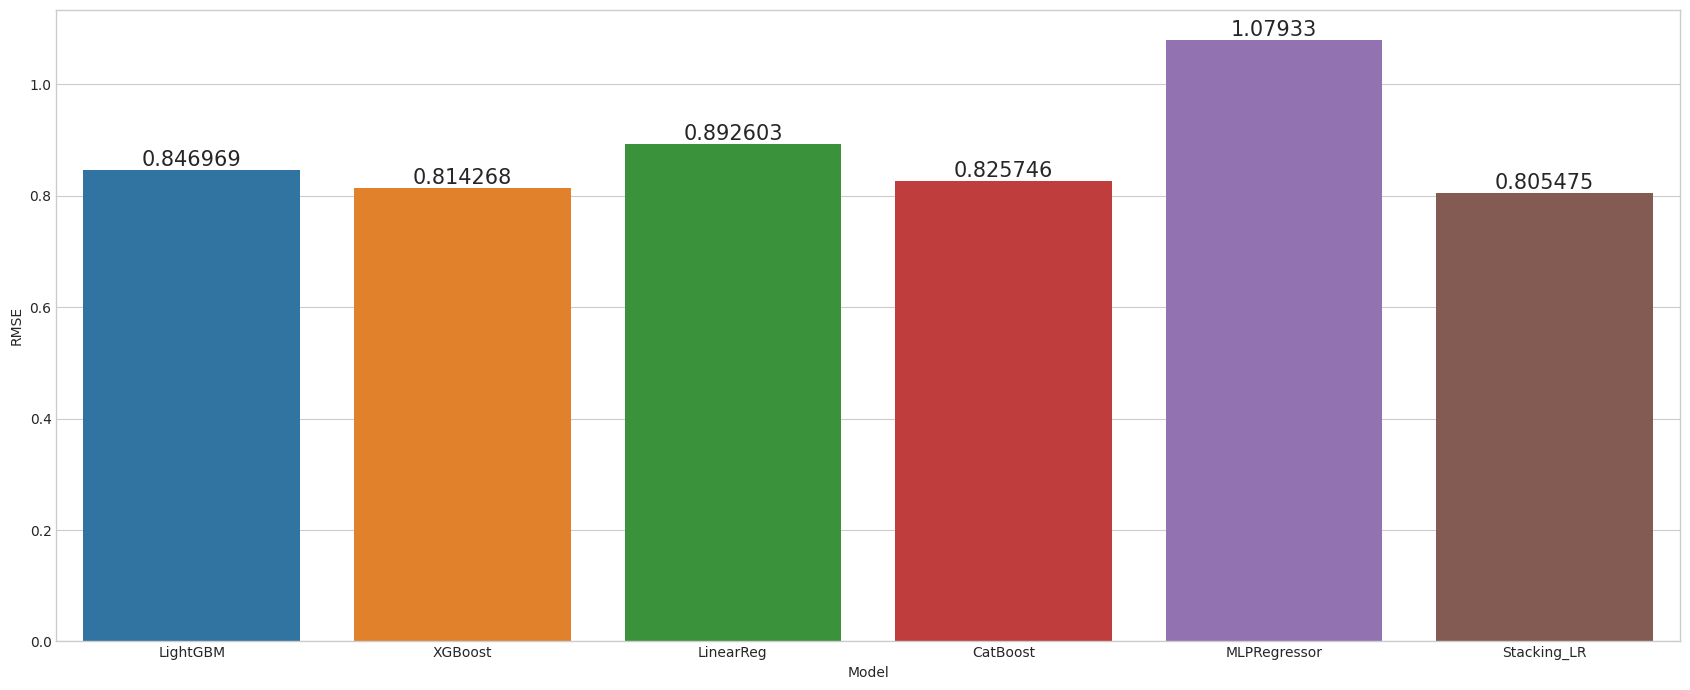

In [131]:
ax = sns.barplot(models_summary, x='Model', y="RMSE")
ax.bar_label(ax.containers[0], fontsize=15);

> **As we can see it gets much better when stacking models predictions with Linear Regression**